# Script to explore radar picks

## Import packages

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
from haversine import haversine, Unit
import numpy as np
import pandas as pd


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## set basic parameters

In [2]:

# define cores

class core:
    def __init__(self, name, lat, lon, depth):
        self.name = name
        self.lat = lat
        self.lon = lon
        self.depth = depth

    def get_dist_to_track(self,lat,lon):

        self.track_dist=10000
        for i in range(len(lat)):
            d = haversine((lat[i],lon[i]),(self.lat,self.lon),unit=Unit.METERS)
            if d < self.track_dist:
                self.track_dist = d
                self.track_idx = i

ALHIC2302 = core('ALHIC2302',-76.74543,159.37513, 143)
ALHIC2201 = core('ALHIC2201',-76.732027,159.359551, 90)
ALHIC1902 = core('ALHIC1902',-76.745357,159.374108, 206.53)
ALHIC1901 = core('ALHIC1901',-76.732376,159.356125, 159.84)


## Calculate true dip

In [3]:
# define function for weighted_percentile
def weighted_percentile(values, weights, percentiles):
    
    # Convert percentiles to fractions
    percentiles = [p / 100 for p in percentiles]

    # Convert values and weights to numpy arrays
    values = np.array(values)
    weights = np.array(weights)
    percentiles = np.array(percentiles)

    # Check for NaN values and remove them
    nan_mask = np.isnan(values) | np.isnan(weights)
    if np.any(nan_mask):
        print("NaN values found and will be removed.")
    values = values[~nan_mask]
    weights = weights[~nan_mask]
    
    # Sort values and weights by values
    sorted_indices = np.argsort(values)
    sorted_values = values[sorted_indices]
    sorted_weights = weights[sorted_indices]
    
    # Compute the cumulative sum of weights
    cumulative_weights = np.cumsum(sorted_weights)
    
    # Normalize the cumulative weights to get the cumulative distribution
    cumulative_distribution = cumulative_weights / cumulative_weights[-1]
    
    # Interpolate to find the weighted percentiles
    weighted_percentiles = np.interp(percentiles, cumulative_distribution, sorted_values)
    
    return weighted_percentiles

# define function to calculate percentiles from dataframe with true dip angles
def calc_percentiles(df,percentiles):

    # initialize list to store dip statistics
    dip_stats = []
    # define if we are looking at AC or DC (AC is default)
    ACorDC = 'AC'

    # loop through each row in the dataframe
    for index,row in df.iterrows():

        # pull out approriate data
        dip = np.array(row[ACorDC+'-true-angles'])
        scores = np.array(row[ACorDC+'-true-scores'])
        
        # plot dip
        a = weighted_percentile(dip, scores, percentiles)
       # weighted_percentile(dip, percentiles, weights=scores, interpolation='step')
        dip_stats.append(a)

        # check
        for i in range(len(a)-1):
            if a[i]>a[i+1]:
                print('Error: Percentiles are not in order in section '+row['section'])

    df['dip_percentiles']  = dip_stats
    return df

In [4]:
#deine percentiles
percentiles = [10,25,50,75,90]

# Load data
alhic2302_angle = pd.read_pickle('../../data/angles/alhic2302_angles.df')
alhic2201_angle = pd.read_pickle('../../data/angles/alhic2201_angles.df')

# calculate true dip percentiles for alhic2201 and alhic2302
alhic2201_angle = calc_percentiles(alhic2201_angle,percentiles)
alhic2302_angle = calc_percentiles(alhic2302_angle,percentiles)

NaN values found and will be removed.
NaN values found and will be removed.


## Basic data import and exploration

In [5]:
# Function to load the shapefile and check basic information
def load_shapefile(file_path):
    try:
        # Load the shapefile using geopandas
        gdf = gpd.read_file(file_path)
        
        # Display basic information about the data
        print("Loaded shapefile successfully!")
        print("Number of features:", len(gdf))
        print("CRS (Coordinate Reference System):", gdf.crs)
        print("First few rows of the data:")
        print(gdf.head())
        
        # Show the columns in the shapefile
        print("\nColumns in the shapefile:")
        print(gdf.columns)

        # You can access the geometry (the spatial component) and attributes here
        print("\nSample geometry:")
        print(gdf.geometry.head())

    except Exception as e:
        print(f"Error loading shapefile: {e}")

    return gdf

# Provide the path to the .shp file
#shapefile_path = "../../../radar_picks/picks-v2-culled-2melev.shp"
shapefile_path = "../../../radar_picks/picks-v2-culled.shp"
gdf = load_shapefile(shapefile_path)


Loaded shapefile successfully!
Number of features: 26422
CRS (Coordinate Reference System): EPSG:3031
First few rows of the data:
  Filename  St. Scan  End Scan      Lat()      Long() Layer 1 Na  Layer 1 Sc  \
0     None         0      6008 -76.733516  159.345061    Layer 1        1640   
1     None         0      6008 -76.733500  159.345184    Layer 1        1650   
2     None         0      6008 -76.733482  159.345314    Layer 1        1660   
3     None         0      6008 -76.733463  159.345453    Layer 1        1670   
4     None         0      6008 -76.733446  159.345595    Layer 1        1680   

   Layer 1 De  Layer 1 2-  Layer 1 La Layer 2 Na  Layer 2 Sc Layer 2 2-  \
0     296.246     3485.24        3.11    Layer 2        1640       None   
1     293.899     3457.63        3.11    Layer 2        1650       None   
2     290.823     3421.45        3.11    Layer 2        1660       None   
3     288.557     3394.79        3.11    Layer 2        1670       None   
4     285.805 

<Axes: >

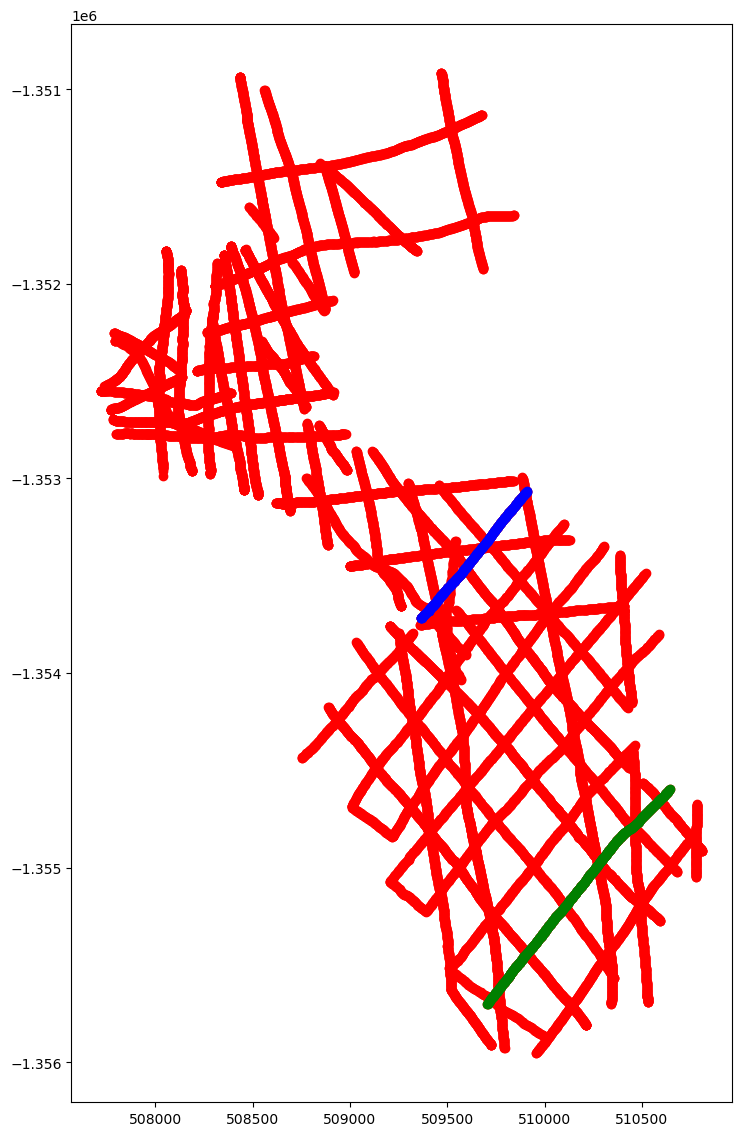

In [6]:
# tool to find the correct lines

fig,ax = plt.subplots(figsize=(14,14))

gdf.plot(ax = ax, color='r')

lo = 1510 # this is right
hi = 1750 # this is right
line23 = gdf[lo:hi]
line23.plot(ax=ax, color='b')

lo = 0 # this is right
hi = 437 # this is right
line02 = gdf[lo:hi]
line02.plot(ax=ax, color='g')



 Distance between ALHIC2302 and line is  24.835536765857537
 Distance between ALHIC1902 and line is  44.851048234582464
Bed slope near ALHIC2302 is  0.6426997198964646  or  32.728843665040266  degrees
 Distance between ALHIC2201 and line is  1.0039180865160766
 Distance between ALHIC1901 and line is  3.1895373898790425
Bed slope near ALHIC2201 is  0.5243448911765873  or  27.67004010623935  degrees


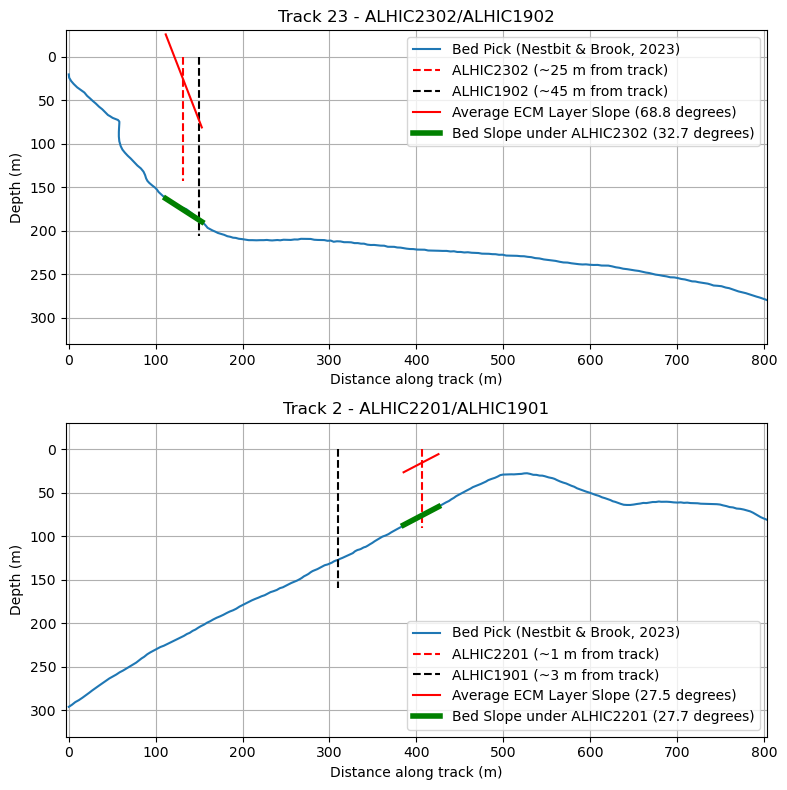

In [7]:
fig,ax = plt.subplots(2,1,figsize=(8,8))

for line,name,ax,cores,core_angle in zip([line23,line02],
                                         ['Track 23','Track 2'],
                                         [ax[0],ax[1]],
                                         [[ALHIC2302,ALHIC1902],[ALHIC2201,ALHIC1901]],
                                         [alhic2302_angle,alhic2201_angle]):
    # Load radar angle data
    angles = []
    angle_depth = []   
    for idx,row in core_angle.iterrows():
        percentiles = row['dip_percentiles']
        median = percentiles[2]
        angle_depth.append(row['depth'])
        angles.append(median)
        
    angle_mean = np.mean(angles)
    angle_depth_mean = np.mean(angle_depth)


    # Get the latitude, longitude, and depth values
    lat = line['Lat()'].to_numpy()
    lon = line['Long()'].to_numpy()
    depth = line['Layer 1 De'].to_numpy()

    # find closest point on line
    for core in cores:
        core.get_dist_to_track(lat,lon)
        print(" Distance between "+core.name+" and line is ",core.track_dist)

    # compute distance along track
    dist = []
    for la,lo in zip(lat,lon):
        dist.append(haversine((lat[0],lon[0]),(la,lo),unit=Unit.METERS))

    # plot the data
    ax.plot(dist,depth,label='Bed Pick (Nestbit & Brook, 2023)')

    # plot core location
    color = ['r--','k--']
    for core,c in zip(cores,color):
        label = core.name + ' (~'+str(round(core.track_dist))+' m from track)'
        ax.plot([dist[core.track_idx],dist[core.track_idx]],[0,core.depth],c,label=label)



    # calculate the bed slope near the core
    core = cores[0] # pick relevant core
    idx = core.track_idx
    dist_min = dist[idx] - 20
    dist_max = dist[idx] + 20
    idx_min = int(round(np.interp(dist_min,dist,range(len(dist)))))
    idx_max = int(round(np.interp(dist_max,dist,range(len(dist)))))
    slope = abs((depth[idx_max] - depth[idx_min])/(dist[idx_max] - dist[idx_min]))
    dip = np.arctan(slope)*180/np.pi
    print('Bed slope near '+core.name+' is ',slope,' or ',dip,' degrees')

    # Plot ECM angle
    hor = (dist[idx_max] - dist[idx_min])/2
    if name == 'Track 23':
        mult = 1
    else:
        mult = -1
    offset = hor * np.tan(angle_mean*np.pi/180)
    ax.plot([dist[idx_min],dist[idx_max]],
            [angle_depth_mean-offset*mult,angle_depth_mean+offset*mult],
            'r',
            label = 'Average ECM Layer Slope ('+str(round(angle_mean,1))+' degrees)')


    # plot the bed slope
    ax.plot([dist[idx_min],dist[idx_max]],[depth[idx_min],depth[idx_max]],
            'g',
            label='Bed Slope under '+core.name+' ('+str(round(dip,1))+' degrees)',
            linewidth=4)

    # set axis to equal scale
    ax.axis('equal')

    # apply x axis limits
    if name == 'Track 23':
        ax.set_xlim(0,800)
        ax.legend(loc='upper right')
    else:
        ax.set_xlim(0,800)
        ax.legend(loc='lower right')


    # plot housekeeping
    title = name + ' - ' + cores[0].name +'/'+cores[1].name 
    ax.set_title(title)
    ax.set_xlabel('Distance along track (m)')
    ax.set_ylabel('Depth (m)')
    ax.set_ylim(300,0)
    ax.grid(True)

fig.tight_layout()

# get size
#sz = fig.get_size_inches()
#fig.set_size_inches(sz[0]*1.5, sz[1]*1.5)

In [8]:
row

section                                                                 26_1
depth                                                              22.633901
AC-r-angles                [-15.0, -19.0, -20.0, -15.0, -21.0, -21.0, -19...
AC-r-scores                [0.9852752398513833, 0.9770993990246436, 0.974...
AC-r-length                [0.4800000000000004, 0.4800000000000004, 0.480...
10-90 percentile spread                                              1.38425
DC-r-angles                [-25.0, -22.0, -49.0, -25.0, -25.0, -25.0, 0.0...
DC-r-scores                [0.5279736359099128, 0.4367027095853503, 0.485...
DC-r-length                [0.41999999999999815, 0.41999999999999815, 0.4...
AC-t-angles                [-17.0, -16.0, -16.0, -17.0, -18.0, -17.0, -18...
AC-t-scores                [0.9493304776004163, 0.9286386690247244, 0.897...
AC-t-length                [0.3200000000000003, 0.3200000000000003, 0.320...
DC-t-angles                [59.0, 59.0, 73.0, 62.0, -61.0, 45.0, -70.0, -...

In [9]:
core.name

'ALHIC2201'

In [10]:
fig.get_size_inches()

array([8., 8.])